# EDA - Partition Selection

In [1]:
# Suppress native-hadoop warning
!sed -i '$a\# Add the line for suppressing the NativeCodeLoader warning \nlog4j.logger.org.apache.hadoop.util.NativeCodeLoader=ERROR,console' /$HADOOP_HOME/etc/hadoop/log4j.properties

In [2]:
import sys
sys.path.append('/home/work')

In [3]:
import pyspark
from pyspark.sql import SparkSession, functions as f
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, avg, min, max, stddev, median

from data.utils.data_loader import load_file_from_hdfs
from data.utils.data_loader import load_from_hdfs

In [4]:
conf = pyspark.SparkConf()
settings = conf.getAll()

# Set Spark Settings
conf = pyspark.SparkConf().setAll([
('spark.master', 'local[*]'),
('spark.app.name', 'MusicRecommender'),
('spark.driver.memory','14g')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# Print the Spark Session settings
settings = spark.sparkContext.getConf().getAll()
for s in settings:
    print(s)

('spark.driver.port', '36505')
('spark.executor.id', 'driver')
('spark.app.startTime', '1717565568601')
('spark.driver.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false')
('spark.app.id', 'local-1717565569209')
('spark.app.su

Load training and test datasets

In [5]:
# Load the dataset
dataset = 'raw'
partitions = 10
train_data, test_data = load_from_hdfs(dataset, partitions)

# Cache the dataframes
train_data.cache()
test_data.cache()

Loaded 699640226 training records and 18231790 test records from HDFS
root
 |-- user_id: integer (nullable = true)
 |-- song_id: integer (nullable = true)
 |-- rating: integer (nullable = true)
 |-- partition_id: integer (nullable = false)



DataFrame[user_id: int, song_id: int, rating: int, partition_id: int]

Function for plotting a box plot illustrating the distribution of ratings per user or the frequency of rating counts. 

In [6]:
def boxplot_user_ratings_distribution(df, ax=None, partition=None):
    user_rating_counts = df.groupBy("user_id").count().sort("count")
    user_rating_counts = user_rating_counts.withColumnRenamed("count", "rating_count")
    
    # uncomment to show frequency of each rating count
    user_rating_counts = user_rating_counts.groupBy("rating_count").count()
    
    user_rating_counts = user_rating_counts.toPandas()
    if ax is None:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='rating_count', data=user_rating_counts)
        plt.title("User Ratings Distribution")
        plt.xlabel("Ratings")
        plt.ylabel("Users")
        plt.show()
    else:
        sns.boxplot(x="rating_count", data=user_rating_counts, ax=ax)
        ax.set_title(f"Partition {partition}")
        ax.set_xlabel("Ratings")
        ax.set_ylabel("Users")

Function for plotting a histogram illustrating the distribution of ratings per user or the frequency of rating counts.

In [7]:
def histplot_user_ratings_distribution(df, ax=None, partition=None):
    user_rating_counts = df.groupBy("user_id").count().sort("count")
    user_rating_counts = user_rating_counts.withColumnRenamed("count", "rating_count")
    
    # uncomment to show frequency of each rating count
    user_rating_counts = user_rating_counts.groupBy("rating_count").count()
    
    user_rating_counts = user_rating_counts.toPandas()
    if ax is None:
        plt.figure(figsize=(10, 6))
        sns.histplot(x='rating_count', data=user_rating_counts)
        plt.title("User Ratings Distribution")
        plt.xlabel("Ratings")
        plt.ylabel("Users")
        plt.show()
    else:
        sns.histplot(x="rating_count", data=user_rating_counts, ax=ax)
        ax.set_title(f"Partition {partition}")
        ax.set_xlabel("Ratings")
        ax.set_ylabel("Users")

Function for plotting a bar plot illustrating the distribution of ratings.

In [8]:
def barplot_rating_distribution(df, ax=None, partition=None):
    ratings = df.groupBy("rating").count().sort("rating")
    colors = sns.color_palette("RdYlGn", 5)
    ratings = ratings.toPandas()
    
    if ax is None:
        plt.figure(figsize=(10, 6))
        sns.barplot(x="rating", y="count", data=ratings, palette=colors)
        plt.title("Rating Distribution")
        plt.xlabel("Rating")
        plt.ylabel("Count")
        plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: format(int(x), ',')))
        plt.show()
    else:
        sns.barplot(x="rating", y="count", data=ratings, ax=ax, palette=colors)
        ax.set_title(f"Partition {partition}")
        ax.set_ylabel("Count")
        ax.set_xlabel("Rating")
        ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: format(int(x), ',')))

Plot a boxplot illustrating the distribution of ratings per user across the entire training set.

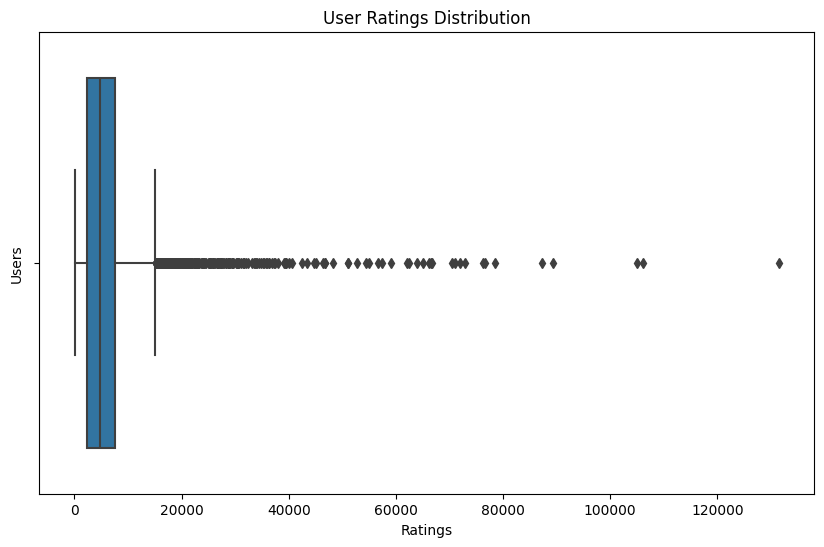

In [9]:
boxplot_user_ratings_distribution(train_data)

User distribution seems to be extremely skewed and have many outliers, as revealed by the points outside the whiskers on the right. The boxplot seems to lie between 0 to 20000, revealing the majority of the users have less than 20000 ratings.

Plot ten boxplots illustrating the distribution of ratings per user across each partition.

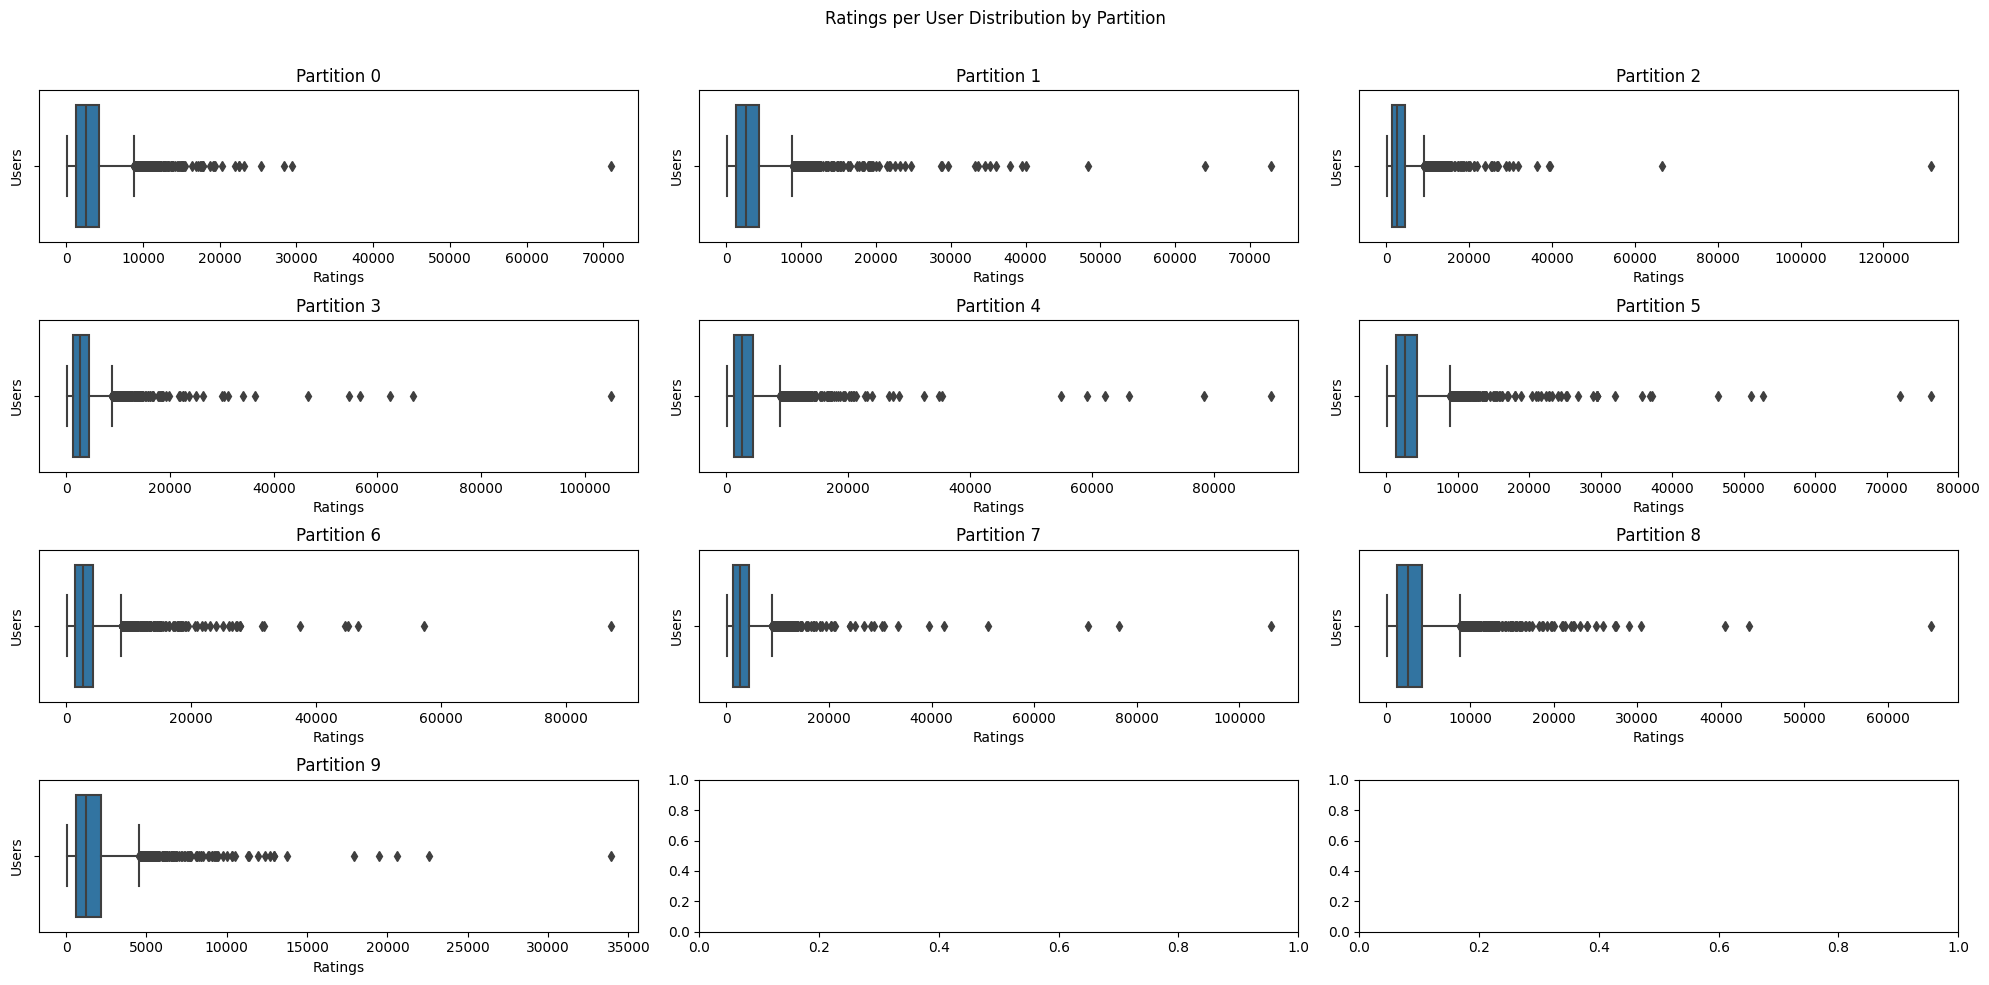

In [10]:
# plot_partitions = [i for i in range(partitions)]
maxCols = 3
rows = (partitions // maxCols) + 1

# Plot ratings per user distribution for each partition
fig, ax = plt.subplots(rows, maxCols, figsize=(20, 10))
fig.suptitle(f"Ratings per User Distribution by Partition")
for i in range(partitions):
    train_data_partition = train_data.filter(f.col("partition_id") == i)
    row = i // maxCols
    col = i % maxCols
    boxplot_user_ratings_distribution(train_data_partition, ax=ax[row, col], partition=i)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

The box plots across the partitions seem to be similar to the overall boxplot.

Plot a histogram illustrating the distribution of ratings per user across the entire training set.

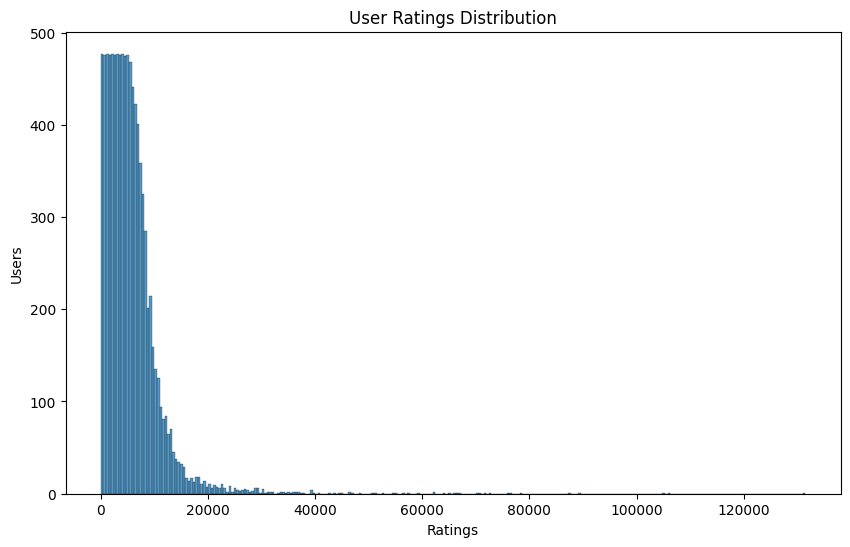

In [11]:
histplot_user_ratings_distribution(train_data)

The distribution reveals matching information from the boxplots. The distributions are extremely skewed and needs to be balanced to achieve accurate results.

Plot ten histograms illustrating the distribution of ratings per user across each partition.

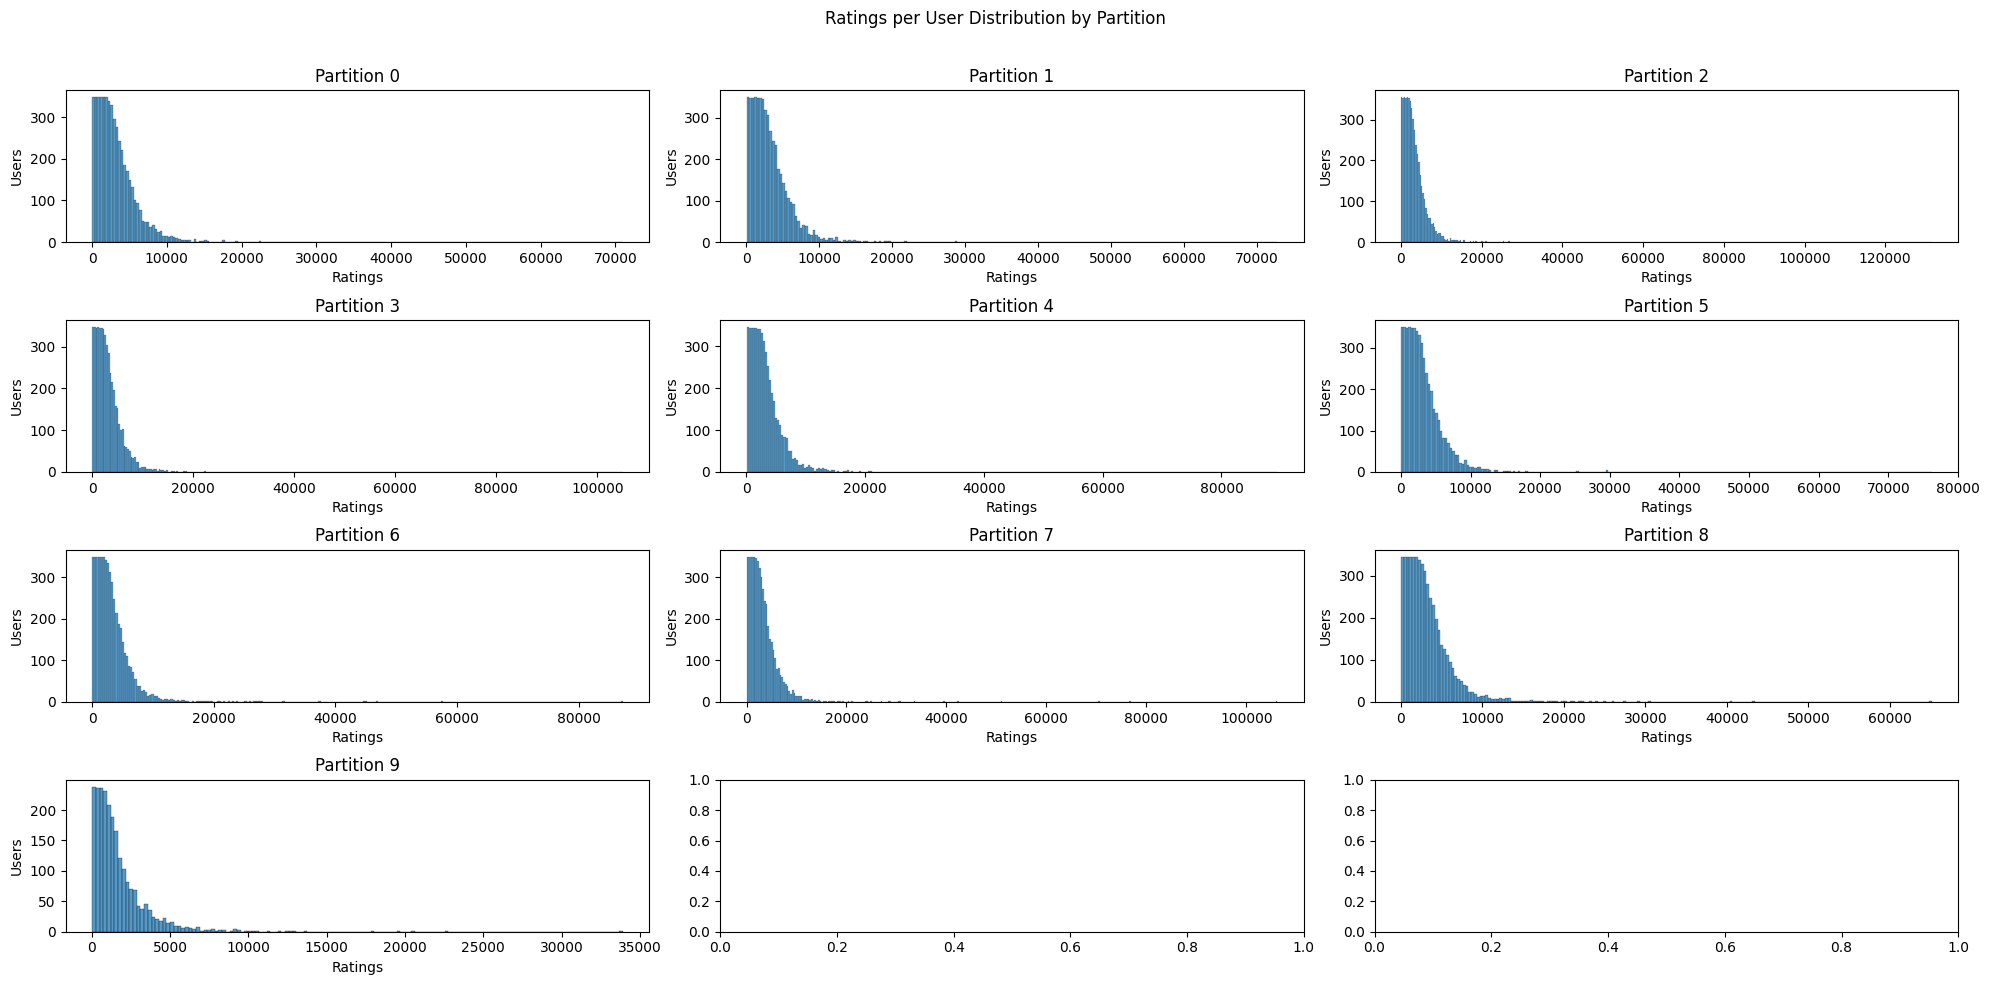

In [12]:
# plot_partitions = [i for i in range(partitions)]
maxCols = 3
rows = (partitions // maxCols) + 1

# Plot ratings per user distribution for each partition
fig, ax = plt.subplots(rows, maxCols, figsize=(20, 10))
fig.suptitle(f"Ratings per User Distribution by Partition")
for i in range(partitions):
    train_data_partition = train_data.filter(f.col("partition_id") == i)
    row = i // maxCols
    col = i % maxCols
    histplot_user_ratings_distribution(train_data_partition, ax=ax[row, col], partition=i)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

The plots seem to match the overall plot. We decided to use partition 2 to be the representative dataset since it seems to be the least skewed and matched the overall dataset well.

Plot a bar plot illustrating the distribution of ratings across the entire training set.

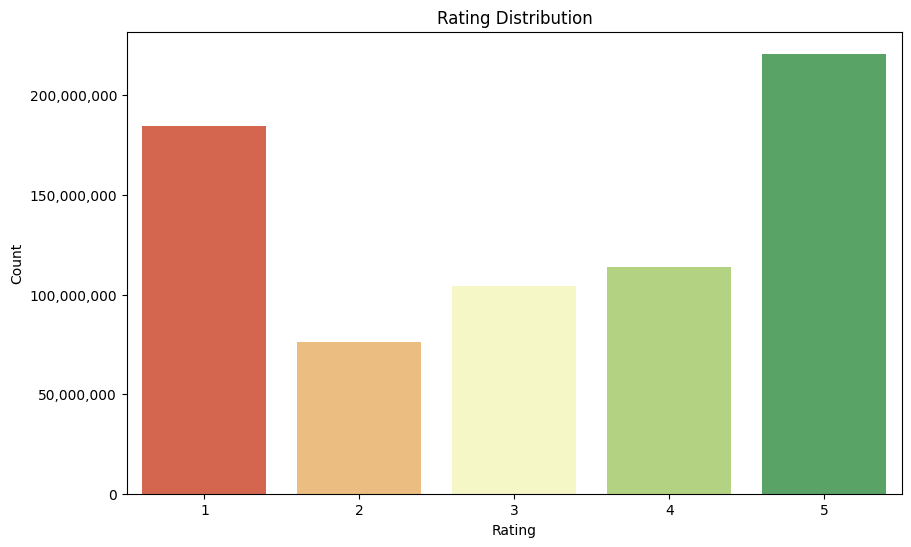

In [13]:
barplot_rating_distribution(train_data)

Most songs seem to be rated either a 1 or 5, but mostly 5!

Plot ten bar plots illustrating the distribution of ratings across each partition.

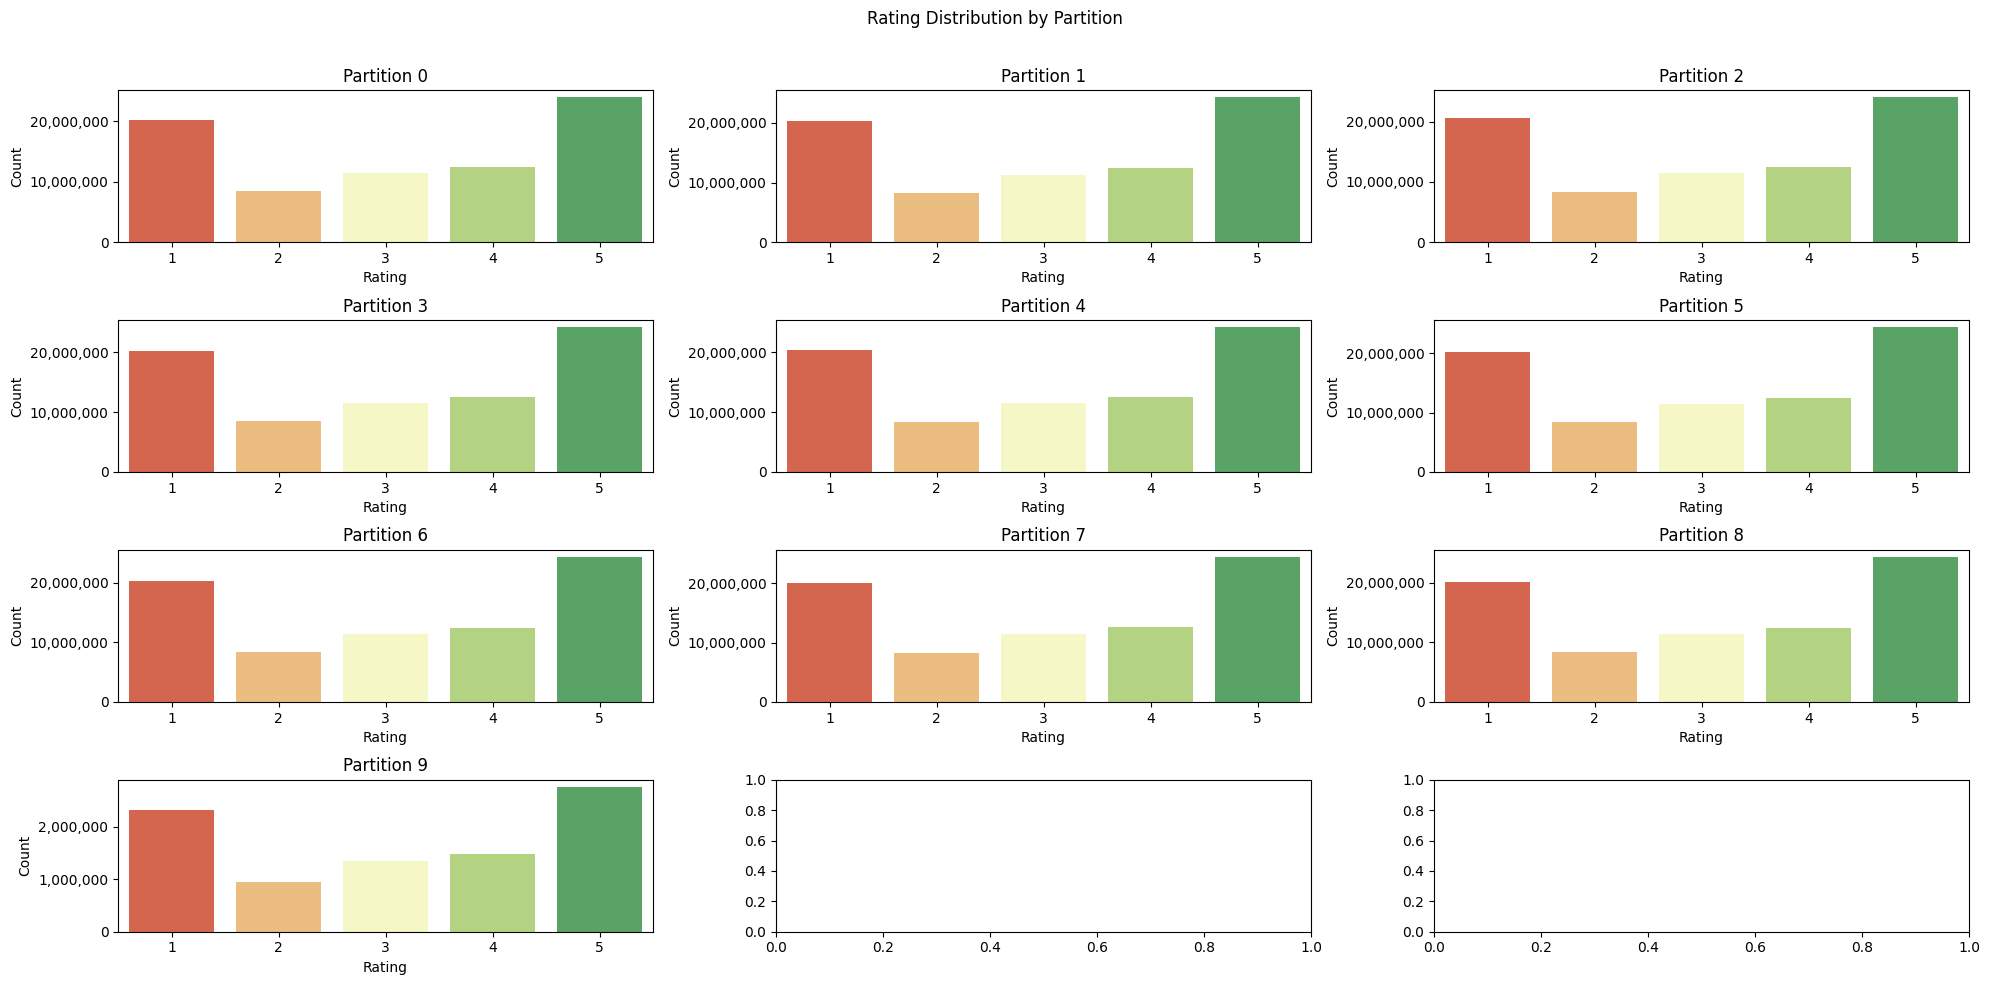

In [14]:
# Plot the distribution of rating scores for each partition
fig, ax = plt.subplots(rows, maxCols, figsize=(20, 10))
fig.suptitle(f"Rating Distribution by Partition")
for i in range(partitions):
    train_data_partition = train_data.filter(f.col("partition_id") == i)
    row = i // maxCols
    col = i % maxCols
    barplot_rating_distribution(train_data_partition, ax=ax[row, col], partition=i)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

Partitions seems to follow the same pattern as the overall rating distribution.

# EDA - Visualizations

Load a choosen partition of song ratings (partition 2: train_2.txt), song attributes, and genre hierarchy.

In [15]:
song_ratings_file_path = "raw/train/train_2.txt"
song_ratings = load_file_from_hdfs(song_ratings_file_path).cache()

song_attributes_file_path = "song-attributes.txt"
song_attributes = load_file_from_hdfs(song_attributes_file_path).cache()

genre_hierarchy_file_path = "genre-hierarchy.txt"
genre_hierarchy = load_file_from_hdfs(genre_hierarchy_file_path).cache()

Display first 5 row of song ratings dataframe

In [16]:
song_ratings.show(5)

+------+---+---+
|   _c0|_c1|_c2|
+------+---+---+
|400000| 87|  3|
|400000|266|  5|
|400000|290|  1|
|400000|544|  5|
|400000|545|  4|
+------+---+---+
only showing top 5 rows



Display first 5 row of song attributes dataframe

In [17]:
song_attributes.show(5)

+---+-----+----+---+
|_c0|  _c1| _c2|_c3|
+---+-----+----+---+
|  0|12070|8490|  0|
|  1|19512|7975|134|
|  2|18953|3492|  0|
|  3|  695|2653|  0|
|  4|  243|2282|  0|
+---+-----+----+---+
only showing top 5 rows



Display first 5 row of genre hierarchy dataframe

In [18]:
genre_hierarchy.show(5)

+---+---+---+----------------+
|_c0|_c1|_c2|             _c3|
+---+---+---+----------------+
|  0|  0|  1|         Unknown|
|  1|  1|  1|Electronic/Dance|
|  2|  1|  2|         Ambient|
|  3|  2|  3|     Ambient Dub|
|  4|  2|  3|    Ambient Tech|
+---+---+---+----------------+
only showing top 5 rows



Update column names for all dataframes

In [19]:
song_ratings = song_ratings.withColumnRenamed("_c0", "user_id") \
    .withColumnRenamed("_c1", "song_id") \
    .withColumnRenamed("_c2", "rating") 

song_attributes = song_attributes.withColumnRenamed("_c0", "song_id") \
    .withColumnRenamed("_c1", "album_id") \
    .withColumnRenamed("_c2", "artist_id") \
    .withColumnRenamed("_c3", "genre_id")

genre_hierarchy = genre_hierarchy.withColumnRenamed("_c0", "genre_id") \
    .withColumnRenamed("_c1", "parent_genre_id") \
    .withColumnRenamed("_c2", "level") \
    .withColumnRenamed("_c3", "genre_name")

Function to check for null values within the columns in the dataframe.

In [20]:
def check_missing_values(df):
    null_columns = {column: df.filter(col(column).isNull()).count() for column in df.columns}
    print(null_columns)
    return None

Check for missing values

In [21]:
check_missing_values(song_ratings)
check_missing_values(song_attributes)
check_missing_values(genre_hierarchy)

TypeError: 'int' object is not callable

Drop duplicates

In [ ]:
song_ratings = song_ratings.dropDuplicates()
song_attributes = song_attributes.dropDuplicates()
genre_hierarchy = genre_hierarchy.dropDuplicates()

Song Ratings - EDA

In [ ]:
song_ratings.show(5)

In [ ]:
print("The schema of the song ratings dataframe:")
song_ratings.printSchema()

In [ ]:
print("Summary Statistics:")
song_ratings.summary().show()

In [ ]:
ratings = song_ratings.count()
print("Number of ratings: ", ratings)

In [ ]:
rating_range = song_ratings.agg(min("rating").alias("min_rating"), max("rating").alias("max_rating")).collect()[0]
print("Range of ratings:", rating_range)

In [ ]:
avg_rating = song_ratings.agg({"rating": "avg"}).collect()[0][0]
print("Average rating:", avg_rating)

In [ ]:
stddev_rating = song_ratings.select(stddev(col("rating"))).collect()[0][0]
print("Standard deviation rating:", stddev_rating)

In [ ]:
users = song_ratings.groupBy("user_id").count()
print("Number of unique users: ", users.count())

In [ ]:
songs = song_ratings.groupBy("song_id").count()
print("Number of unique songs: ", songs.count())

Song Attributes - EDA

In [ ]:
song_attributes.show(5)

In [ ]:
print("The schema of the song attributes dataframe:")
song_attributes.printSchema()

In [ ]:
artists = song_attributes.groupBy("artist_id").count()
print("Number of unique artist: ", artists.count())

In [ ]:
albums = song_attributes.groupBy("album_id").count()
print("Number of unique album: ", albums.count())

Genre Hierarchy - EDA

In [ ]:
genre_hierarchy.show(5)

In [ ]:
print("The schema of the genre dataframe:")
genre_hierarchy.printSchema()

In [ ]:
genres = genre_hierarchy.groupBy("genre_id").count()
print("Number of unique genre: ", genres.count())

In [ ]:
levels = genre_hierarchy.groupBy("level").count()
print("Number of unique level: ", levels.count())

Join the song_ratings dataframe with the song_attributes and genre_hierarchy dataframes

In [ ]:
df = song_ratings.join(song_attributes, "song_id", how="inner")
df = df.join(genre_hierarchy,"genre_id", how="inner")

In [ ]:
df.printSchema()

In [ ]:
check_missing_values(df)

In [ ]:
df.show(5)

Top 100 Highest Ratings Songs - EDA

In [ ]:
df = df.sample(withReplacement=False, fraction=1.0, seed=42)

In [ ]:
songs_avg_rating = df.groupBy("song_id").agg(avg("rating").alias("avg_rating"))
top_100_song = songs_avg_rating.orderBy("avg_rating", ascending=False).limit(100)
top_100_song.show()

In [ ]:
top_100_song = top_100_song.join(df, "song_id", how="left")
top_100_song = top_100_song.select("song_id", "avg_rating", "genre_id", "user_id", "rating", "album_id", "artist_id", "genre_name")

In [ ]:
top_rating_range = top_100_song.agg(min("rating").alias("min_rating"), max("rating").alias("max_rating")).collect()[0]
print("Range of ratings of top 100 songs:", top_rating_range)

In [ ]:
top_avg_rating = top_100_song.select(avg(col("rating"))).collect()[0][0]
print("Average ratings of top 100 songs:", top_avg_rating)

In [ ]:
median_rating = top_100_song.select(median(col("rating"))).collect()[0][0]
print("Median ratings of top 100 songs:", median_rating)

In [ ]:
top_artists_count = top_100_song.groupBy("artist_id").count()
print("Number of artists in the top 100 songs: ", top_artists_count.count())

In [ ]:
top_albums_count = top_100_song.groupBy("album_id").count()
print("Number of albums in the top 100 songs: ", top_albums_count.count())

In [ ]:
top_genre_count = top_100_song.groupBy("genre_name").count().toPandas()
print("Number of genres in the top 100 songs: ", top_genre_count.count())

plt.figure(figsize=(8, 8))
plt.pie(top_genre_count['count'], labels=top_genre_count['genre_name'], autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Distribution of Songs by Genre')
plt.axis('equal')  
plt.show()

##### Visualizations

Genre Rating Distribution

In [ ]:
user_rating_counts = df.groupBy("user_id").count().sort("count")
user_rating_counts = user_rating_counts.withColumnRenamed("count", "rating_count")

user_rating_counts = user_rating_counts.groupBy("rating_count").count()
user_rating_counts = user_rating_counts.toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(x='rating_count', data=user_rating_counts)
plt.title("User Ratings Distribution")
plt.xlabel("Ratings")
plt.ylabel("Users")
plt.show()

User Rating Distribution

In [ ]:
genre_pdf = df.select('genre_name').toPandas()
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# no log
sns.countplot(data=genre_pdf, x='genre_name', ax=axes[0])
axes[0].set_title('Genre Rating Distribution (Not Log Scale)')
axes[0].set_xlabel('Genre')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=90)

# log
sns.countplot(data=genre_pdf, x='genre_name', ax=axes[1])
axes[1].set_title('Genre Rating Distribution (Log Scale)')
axes[1].set_xlabel('Genre')
axes[1].set_ylabel('Count (log scale)')
axes[1].set_yscale('log')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

Rating Spread by Genre

In [ ]:
pdf = df.toPandas()
sns.boxplot(data=pdf, x='genre_name', y='rating')
plt.title('Rating Spread by Genre')
plt.xlabel('Genre')
plt.ylabel('Ratings')
plt.xticks(rotation=90)
plt.show()

Average Ratings by Genre

In [ ]:
genre_rating_avg_pdf = df.groupBy('genre_name').avg('rating').toPandas()

plt.scatter(data=genre_rating_avg_pdf, x='genre_name', y='avg(rating)')
plt.title('Average Ratings by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Ratings')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Top 10 Artists

In [ ]:
# top 10 artist (detemined by number of ratings)
artist_ratings_count = df.groupBy('artist_id').count()
top_10_artists = artist_ratings_count.orderBy('count', ascending=False).limit(10)
top_10_artists_pdf= top_10_artists.toPandas()

sns.barplot(data=top_10_artists_pdf, x='artist_id', y='count')
plt.title('Top 10 Artists')
plt.xlabel('Artist ID')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=60)
plt.show()


Average Ratings by Top Artists

In [ ]:
top_10_artists_df = top_10_artists.join(df, 'artist_id', 'inner')
top_artists_rating_avg_pdf= top_10_artists_df.groupBy('artist_id').avg('rating').toPandas()

plt.scatter(data=top_artists_rating_avg_pdf, x='artist_id', y='avg(rating)')
plt.title('Average Ratings by Top Artists')
plt.xlabel('Artist ID')
plt.ylabel('Average Ratings')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

Rating Spread by Top 10 Artists

In [ ]:
sns.boxplot(data=top_10_artists_df.toPandas(), x='artist_id', y='rating')
plt.title('Rating Spread by Top 10 Artists')
plt.xlabel('Artist ID')
plt.ylabel('Ratings')
plt.xticks(rotation=60)
plt.show()

This box plot helps us understand the rating distributions of the top 10 most rated artists. This gives us a better idea of how these artists in our dataset are generally rated. It seems to be mostly a 4 rating all around.

Top 10 Songs

In [ ]:
song_ratings_count = df.groupBy('song_id').count()
top_10_songs = song_ratings_count.orderBy('count', ascending=False).limit(10)
top_10_songs_pdf= top_10_songs.toPandas()

sns.barplot(data=top_10_songs_pdf, x='song_id', y='count')
plt.title('Top 10 Songs')
plt.xlabel('Song ID')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=60)
plt.show()

This barplot shows us how many ratings the top songs have and how many ratings it generally takes to be in the top 10 songs. It also gives insight on possible correlation in the popularity of the song and the recommendations in our future trained model. 

Average Ratings by Top Songs

In [ ]:
top_10_songs_df = top_10_songs.join(df, 'song_id', 'inner')
top_songs_rating_avg_pdf= top_10_songs_df.groupBy('song_id').avg('rating').toPandas()

plt.scatter(data=top_songs_rating_avg_pdf, x='song_id', y='avg(rating)')
plt.title('Average Ratings by Top Songs')
plt.xlabel('Song ID')
plt.ylabel('Average Ratings')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

This scatter plot shows how ratings differ in the top songs, giving us a better visualization of how popular songs are generally rated. Popular songs doesn’t necessarily mean that they are good songs or good recommendations. 

Rating Spread by Top 10 Songs

In [ ]:
sns.boxplot(data=top_10_songs_df.toPandas(), x='song_id', y='rating')
plt.title('Rating Spread by Top 10 Songs')
plt.xlabel('Song ID')
plt.ylabel('Ratings')
plt.xticks(rotation=60)
plt.show()

This box plot helps us understand the rating distributions of the top 10 most rated songs. This gives us a better idea of how these songs in our dataset are generally rated. They seem to be around 3-4 all around.

Songs Breakdown by Genre

In [ ]:
genre_song_count = df.groupBy('genre_name').agg(f.count('song_id').alias('genre_song_count'))
genre_song_count = genre_song_count.orderBy('genre_song_count', ascending=False)
genre_song_count_pdf = genre_song_count.toPandas()
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

sns.barplot(data=genre_song_count_pdf, x='genre_name', y='genre_song_count', ax=axes[0])
axes[0].set_title('Songs Breakdown by Genre')
axes[0].set_xlabel('Genre Name')
axes[0].set_ylabel('Number of Songs')
axes[0].tick_params(axis='x', rotation=90)

sns.barplot(data=genre_song_count_pdf, x='genre_name', y='genre_song_count', ax=axes[1])
axes[1].set_title('Songs Breakdown by Genre')
axes[1].set_xlabel('Genre Name')
axes[1].set_ylabel('Number of Songs (log scale)')
axes[1].set_yscale('log')
axes[1].tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

These bar plots allow us to visualize how the genres are broken down in our dataset. “Unknown” genre makes up a lot of our dataset. Although we were planning on removing genres that are unknown, it is not appropriate in this case since most of our data would be removed if unknowns are filtered out.

Songs Breakdown by Top 10 Albums

In [ ]:
# song in album breakdown top 10 (determined by most rated songs in album)
album_song_count = df.groupBy('album_id').agg(f.count('song_id').alias('album_song_count'))

album_song_count = album_song_count.orderBy('album_song_count', ascending=False).limit(10)

album_song_count_pdf = album_song_count.toPandas()

sns.barplot(data=album_song_count_pdf, x='album_id', y='album_song_count')
plt.title('Songs Breakdown by Top 10 Albums')
plt.xlabel('Album ID')
plt.ylabel('Number of Songs')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

This barplot shows us how many ratings the top albums have and how many ratings it generally takes to be in the top 10 albums. It also gives insight on possible correlation in the popularity of the album and the recommendations in our future trained model. 

Songs Breakdown by Top 10 Artists

In [ ]:
# song in artist breakdown top 10 (determined by most rated songs by artist)
artist_song_count = df.groupBy('artist_id').agg(f.count('song_id').alias('artist_song_count'))

artist_song_count = artist_song_count.orderBy('artist_song_count', ascending=False).limit(10)

artist_song_count_pdf = artist_song_count.toPandas()

sns.barplot(data=artist_song_count_pdf, x='artist_id', y='artist_song_count')
plt.title('Songs Breakdown by Top 10 Artists')
plt.xlabel('Artist ID')
plt.ylabel('Number of Songs')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

This barplot shows us how many ratings the top artists have and how many ratings it generally takes to be in the top 10 artists. It also gives insight on possible correlation in artist popularity and our trained model’s recommendations. 

##### Stop Spark session

In [ ]:
spark.stop()